In [1]:
!pip install arviz==0.6.1
!pip install pymc3==3.8
!pip install Theano==1.0.4

     |████████████████████████████████| 1.4MB 6.0MB/s 
     |████████████████████████████████| 4.7MB 27.8MB/s 
     |████████████████████████████████| 317kB 49.8MB/s 
     |████████████████████████████████| 911kB 4.2MB/s 
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7
     |████████████████████████████████| 2.8MB 4.3MB/s 
  Created wheel for Theano: filename=Theano-1.0.4-cp37-none-any.whl size=2667178 sha256=be40d074277feb015de195294b4e4e889a4542e4b5ccd50ec941f59d10d6e7c4
  Stored in directory: /root/.cache/pip/wheels/88/fb/be/483910ff7e9f703f30a10605ad7605f3316493875c86637014
Successfully built Theano
  Found existing installation: Theano 1.0.5
    Uninstalling Theano-1.0.5:
      Successfully uninstalled Theano-1.0.5


In [54]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib.gridspec import GridSpec
import pymc3 as pm
from sklearn import linear_model
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import scipy.stats as st



### **1) Describe the dataset**

In [3]:
iris = datasets.load_iris()
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

The dataset contains 3 classes of 50 instances each, each class refers to a iris plant (Setosa, Versicolor, Virginica).

In [4]:
irisdf = pd.DataFrame(iris.data, columns= iris.feature_names)


We can transform the dataset to a pandas dataframe and check which kind of data we have

In [5]:
irisdf.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


The variables are the sepal length, sepal width, petal length and petal width, all expressed in centimeters. 
There are 150 observations for each variable as we have seen before. 

The **sepal length** ranges from 4.3 to 7.9 cm. With a mean of 5.8 cm. <br>
The **sepal width** ranges from 2.0 to 4.4 cm. With a mean of 3.1 cm. <br>
The **petal length** ranges from 1.0 to 6.9 cm. With a mean of 3.8 cm.<br>
The **petal width** ranges from 0.1 to 2.5 cm. With a mean of 1.2 cm.<br>

When we make the pandas dataframe the column target is not included, so we will include it as it is in the dataset, and it refers to the type of iris, being the labels the following:

Setosa = 0 <br>
Versiocolor = 1 <br>
Virginica = 2 <br>


In [6]:
irisdf = pd.DataFrame(data = np.c_[iris["data"], iris["target"]], columns=iris["feature_names"] + ["target"])
irisdf["target"] = irisdf["target"].astype(int)
irisdf["iris type"] = pd.Categorical.from_codes(iris.target, iris.target_names)
irisdf.head(10)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,iris type
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa
5,5.4,3.9,1.7,0.4,0,setosa
6,4.6,3.4,1.4,0.3,0,setosa
7,5.0,3.4,1.5,0.2,0,setosa
8,4.4,2.9,1.4,0.2,0,setosa
9,4.9,3.1,1.5,0.1,0,setosa


Now we can plot pairplots for each variable to inspect them.

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


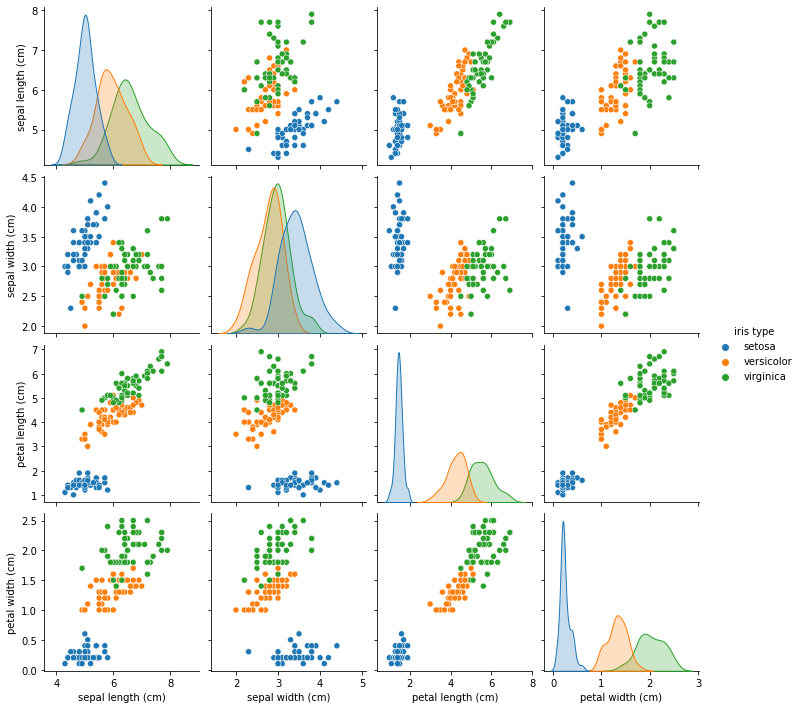

In [7]:
sns.pairplot(irisdf, vars = irisdf.columns[0:4], hue='iris type', size=2.5)

**Distributions**
From the plots of the distributions we can see that are some variables that can be useful to classify the data. For example the petal length and width, that have a clear different distribution between setosa and the other two species.<br>

**Scatter plots**
We can see that here the virginica and versicolor species have similar trends and show some correlations between, for example, petal length and petal width or petal length and sepal length. While the setosa variant, follows different trends and, as it is said in the description of the dataset, it could be linearly separated.<br>
Then we have other pairs of variables such us petal length and sepal width or sepal length and sepal width that are not well correlated between virginica and versicolor and could be useful to separate the data. To confirm our hypothesis we can also make a correlation table


In [8]:
irisdf.iloc[:,0:4].corr()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
sepal length (cm),1.000000,-0.117570,0.871754,0.817941
sepal width (cm),-0.117570,1.000000,-0.428440,-0.366126
petal length (cm),0.871754,-0.428440,1.000000,0.962865
petal width (cm),0.817941,-0.366126,0.962865,1.000000


### **1) Using pyMC3, we want to infer the parameters of the following models:**

#### **a) The mean and standard deviation of the distribution of one feature chosen by you, that we assume as normally distributed.** 

I will choose the **sepal width**, since it is the most similar to a normal distribution. <br>
I already tried to build the model by using priors close to the real mean and standard deviation of the data. But as the model predicts very well, I will use a less subjective priors. The mean between 0 and 50 and the std between 0 and 10. The model will be based on Markov Chain Montecarlo.

In [9]:
with pm.Model() as model_sepwidth:
  # Priors
  mu = pm.Uniform("mu", lower = 0, upper = 50)
  sigma = pm.Uniform("sigma", lower=0, upper = 10)
  # Observed data
  x = pm.Normal("x", mu=mu, sigma=sigma, observed = irisdf["sepal width (cm)"] )
  trace = pm.sample(draws=10000, tune = 5000,step=pm.Metropolis(), cores = 10) # Cores = 10 to sample more chains and have a better convergence 


Multiprocess sampling (10 chains in 10 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [mu]
Sampling 10 chains, 0 divergences: 100%|██████████| 150000/150000 [01:17<00:00, 1923.51draws/s]
The number of effective samples is smaller than 25% for some parameters.


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2b2d710c90>,
      dtype=object)

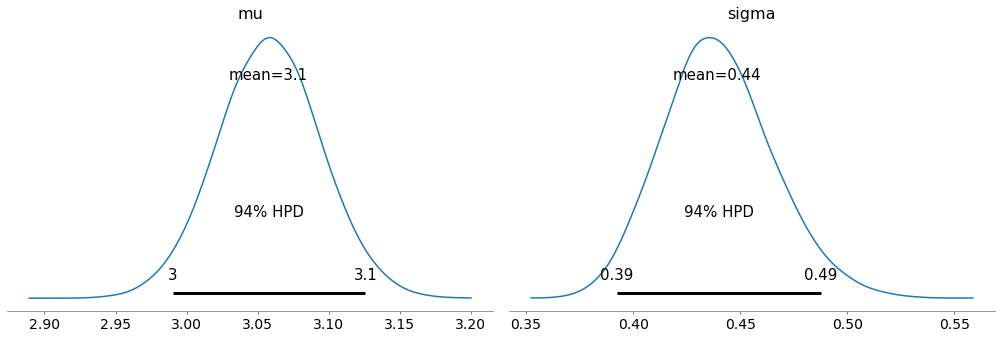

In [10]:
pm.plot_posterior(trace)

/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2b30403c50>,
      dtype=object)

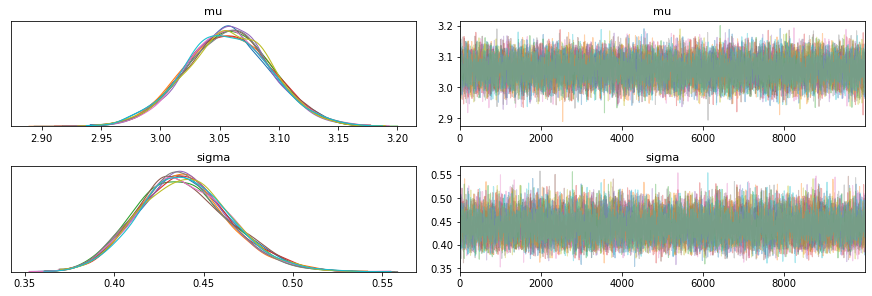

In [11]:
pm.traceplot(trace)

We see how, even giving the model unopinionated guesses, it has converged very well to the real values.

**Real mean** = 3.1	**Model mean** = 3.1 <br>
**Real STD** = 	0.44  **Model STD** = 0.44

#### **b) The Petal Width as linear function of the other three features.**

I will use  Bayesian modelling to infer the parameters of the linear model. For the **features** I will use a Normal distribution (which is more or less what we have seen in our plots) with the mean equal to the mean of each variable, and a std equal to the standard deviation of the features as well. <br>
Then, for the **error** I will use also a Normal distribution with a mean of 0 and a standard deviation that will be the same as the one of the regression coefficients, which will range between 0 and 10. <br>
For the **regression coefficients** I will assume for them a Normal distribution with a mean of 0 and the standard deviation stated before. <br>
Finallly, for the **petal width** I will assume a normal distribution with the std between 0 and 10.


In [12]:
with pm.Model() as model_petwidth:
  # Set the unopinionated standard deviation
  std = pm.Uniform("std", lower=0, upper=100)
  # Variables
  seplen = pm.Normal("seplen", mu=irisdf["sepal length (cm)"].mean(), observed = irisdf["sepal length (cm)"])
  sepwid = pm.Normal("sepwid", mu=irisdf["sepal width (cm)"].mean(), observed = irisdf["sepal width (cm)"])
  petlen = pm.Normal("petlen", mu=irisdf["petal length (cm)"].mean(), observed = irisdf["petal length (cm)"])

  # Error
  error = pm.Normal("error", mu=0, sigma=std)

  # Regression coeficients
  seplen_coeff = pm.Normal("seplen_coeff", mu=0, sigma=std )
  sepwid_coeff = pm.Normal("sepwid_coeff", mu=0, sigma=std )
  petlen_coeff = pm.Normal("petlen_coeff", mu=0, sigma=std )
  par_intercept = pm.Normal("par_intercept", mu=0, sigma=std)


  # Deterministic variables that depends of random variables are set like this
  mean = pm.Deterministic("mean", par_intercept + seplen_coeff*seplen + sepwid_coeff*sepwid + petlen_coeff*petlen)

  # Petal width

  petwid = pm.Normal("petwid", mu=mean, sigma=std, observed=irisdf["petal width (cm)"])

  trace = pm.sample(draws=10000, tune = 5000,step=pm.Metropolis(), cores = 10) 




Multiprocess sampling (10 chains in 10 jobs)
CompoundStep
>Metropolis: [par_intercept]
>Metropolis: [petlen_coeff]
>Metropolis: [sepwid_coeff]
>Metropolis: [seplen_coeff]
>Metropolis: [error]
>Metropolis: [std]
Sampling 10 chains, 0 divergences: 100%|██████████| 150000/150000 [03:21<00:00, 742.72draws/s]
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2b302aaf90>,
      dtype=object)

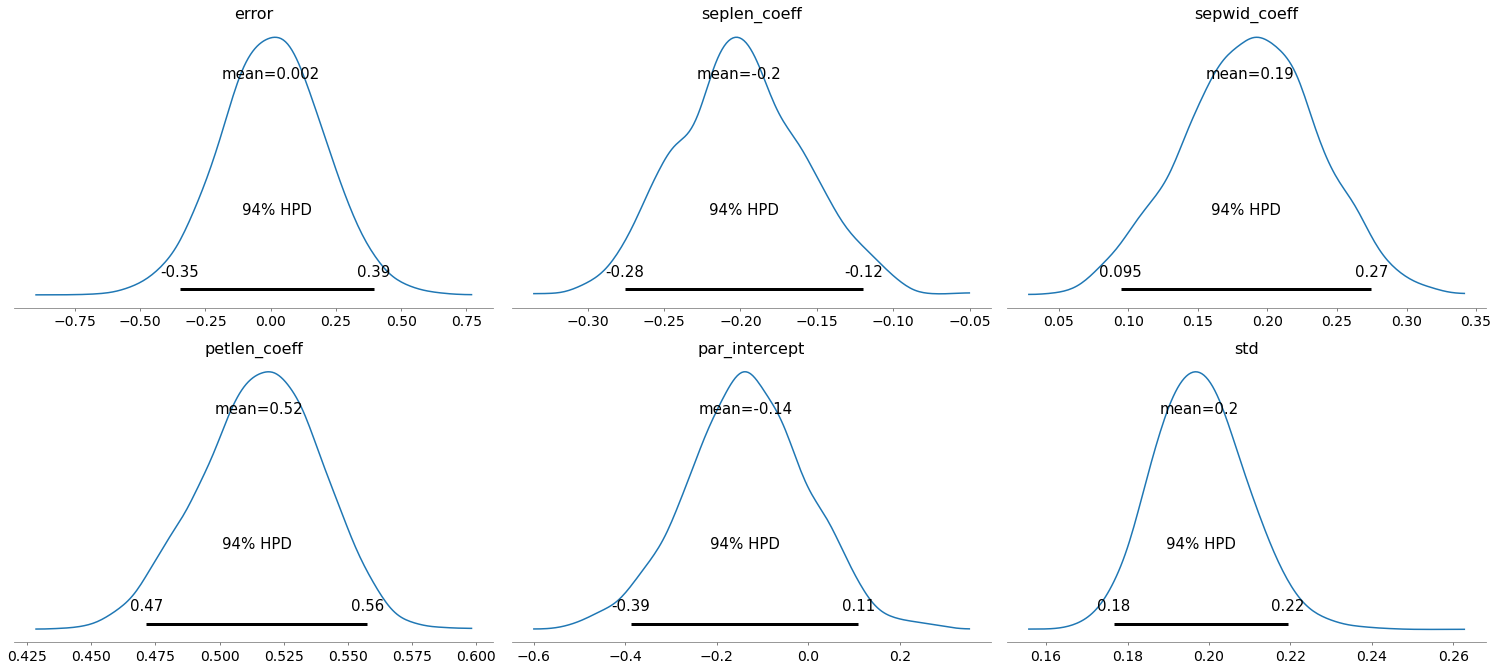

In [13]:
pm.plot_posterior(trace, var_names=["error", "seplen_coeff", "sepwid_coeff", "petlen_coeff", "par_intercept", "std"])

/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2b27947250>,
      dtype=object)

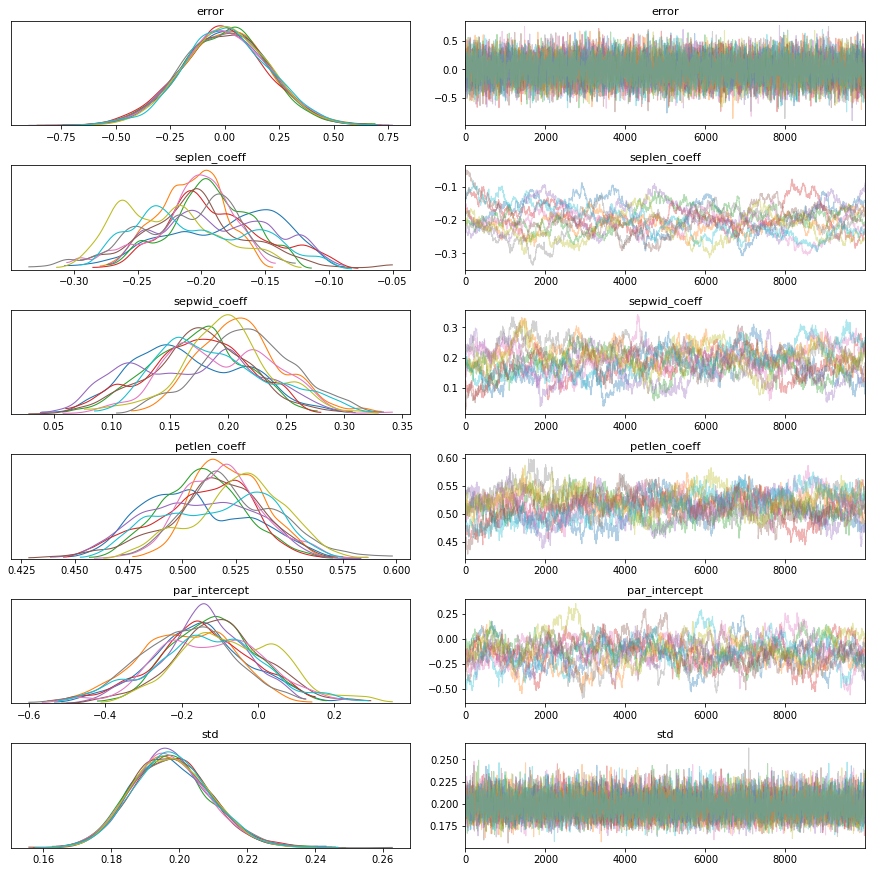

In [14]:
pm.traceplot(trace, var_names=["error", "seplen_coeff", "sepwid_coeff", "petlen_coeff", "par_intercept", "std"])

We can compare now with the frequentist approach. For this we will use a multiple linear regression, that uses a least squares estimation.

In [ ]:
# Select the data
Variables = irisdf[["sepal length (cm)", "sepal width (cm)", "petal length (cm)"]]
Y = irisdf[["petal width (cm)"]]

# Fitting the model
lm = linear_model.LinearRegression()
model = lm.fit(Variables, Y)
# Prediction 
frequentist_predict = lm.predict(Variables)

# Output parameters
print("Regression coefficients:\n seplen = %.3f \n sepwid = %.3f \n petlen = %.3f \n Intercept = %.3f\n" %(lm.coef_[0, 0],lm.coef_[0, 1],lm.coef_[0, 2], lm.intercept_))


Regression coefficients:
 seplen = -0.207 
 sepwid = 0.223 
 petlen = 0.524 
 Intercept = -0.240



In [48]:
pm.summary(trace, var_names=["error", "seplen_coeff", "sepwid_coeff", "petlen_coeff", "par_intercept", "std"])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
error,0.002,0.197,-0.349,0.395,0.001,0.001,19176.0,16616.0,19151.0,19732.0,1.00
seplen_coeff,-0.201,0.042,-0.276,-0.120,0.006,0.004,53.0,52.0,54.0,207.0,1.15
sepwid_coeff,0.187,0.048,0.095,0.275,0.006,0.005,57.0,53.0,57.0,234.0,1.14
petlen_coeff,0.515,0.023,0.471,0.558,0.003,0.002,63.0,62.0,63.0,270.0,1.13
par_intercept,-0.136,0.133,-0.389,0.109,0.013,0.009,108.0,108.0,108.0,273.0,1.07
std,0.198,0.011,0.177,0.219,0.000,0.000,14078.0,14078.0,14076.0,18147.0,1.00


We can see that the distributions of the coefficients infered with PyMC3 have converged quite well and the mean values are close to the values obtained using the frequentist approach. 

So we can be quite happy with the model we have obtained and it will be useful for infer values of petal width taking into account the other three features. It would be also a good idea to compare the RMSE between the frequentist and Bayesian approach to see how good is our model predicting the data.

We see that the obtained means of the  distributions for the bayesian model are not that different from the regression coefficients obtained with the linear regression.

### **3) Clusterize the plants according to its features and analyse the results of the clusters as indication of the type of plants**

I will use KMeans again for clustering. The algorithm I will use is the same I build for the assaignment 3. 

In [ ]:
# Defining the algorithm

import random

class K_Means:

  def __init__(self, k=3, tolerance=0.0001,max_iterations = 500):
      self.k = k
      self.tolerance = tolerance
      self.max_iterations = max_iterations

  def calc_distance (self,X1, X2):
    """ Calculate distances between points of numpy arrrays"""
    return (sum((X1 - X2)**2))**0.5

  def findClosestCentroids(self,ic,X):
    """ finds the closest centroid for each point """
    assigned_centroid = []
    for i in X:
        distance = []
        for j in ic:
           distance.append(self.calc_distance(i,j))
        assigned_centroid.append(np.argmin(distance))
    return assigned_centroid

  def calc_centroids (self,clusters, X):
    """ Calculates the new centroids """
    new_centroids = []
    new_df = pd.concat([pd.DataFrame(X), pd.DataFrame(clusters, columns=['cluster'])], axis = 1)

    for c in set(new_df['cluster']):
        current_cluster = new_df[new_df['cluster'] == c]
        cluster_mean = current_cluster[new_df.columns[:-1]].mean(axis=0).tolist()
        new_centroids.append(cluster_mean)
    return new_centroids   

  def fit(self, data, features):
      # convert the data to numpy array with the desired features
      initial_df = data
      data = data[features]
      X = np.array(data)
      # choose k random centroids
      init_centroids = random.sample(range(0, len(data)), self.k)
      init_centroids # These are the centroids indexes
      centroids = []
      for i in init_centroids:
          centroids.append(data.loc[i])
      centroids = np.array(centroids)

      previous_centroids = centroids
      
      # Start the iteratons
      for i in range(self.max_iterations):
          get_centroids = self.findClosestCentroids(centroids, X)
          centroids = self.calc_centroids(get_centroids, X)

          # Check if the tolerance is achieved
          centroids_distances = []
          for i in range(len(centroids)):
              centroids = np.array(centroids)
              previous_centroids = np.array(previous_centroids)
              centroids_distances.append(self.calc_distance(centroids[i],previous_centroids[i]))
              if sum(centroids_distances) < 3*self.tolerance:
                  break
          previous_centroids = centroids
            
      final_df = pd.concat([pd.DataFrame(initial_df), pd.DataFrame(get_centroids, columns = ['cluster'])], axis = 1)
      return final_df

First we check the optimal number of clusters, although it will not give that much information since we already know that we have 3 clusters.

In [ ]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1,15):
    kmeans = KMeans(i)
    kmeans.fit(irisdf[["sepal length (cm)", "sepal width (cm)", "petal length (cm)", "petal width (cm)"]])
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)


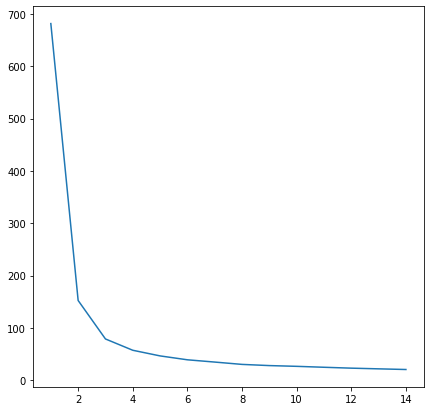

In [ ]:
plt.figure(figsize=(7,7))
number_clusters = range(1,15)
plt.plot(number_clusters, wcss)

We see that the optimal number of clusters is between 3 and 4. But, as I said, I will use k=3 because we already know that we have three different species.

In [ ]:
# Running the algorithm
kmeans = K_Means(3).fit(irisdf, ["sepal length (cm)", "sepal width (cm)", "petal length (cm)", "petal width (cm)"])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

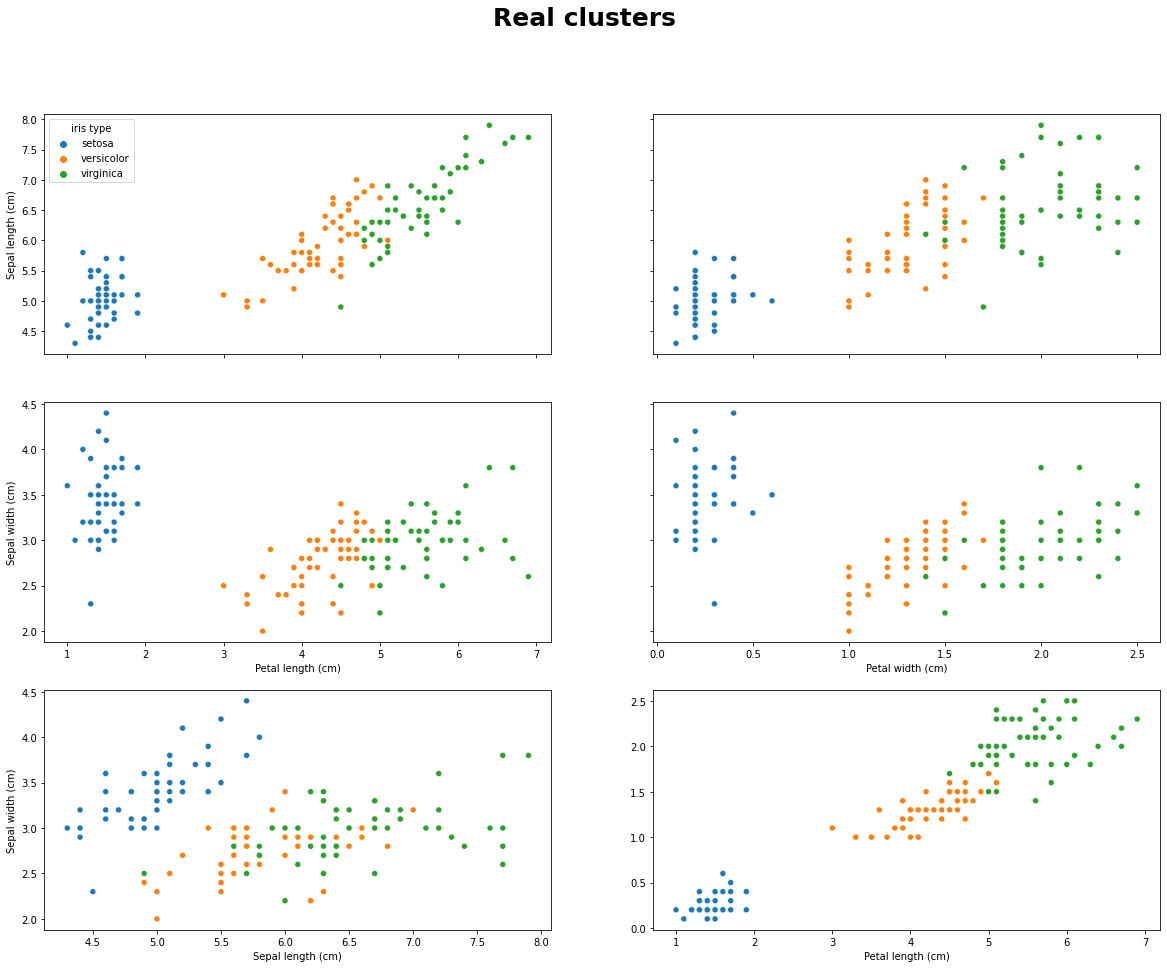

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

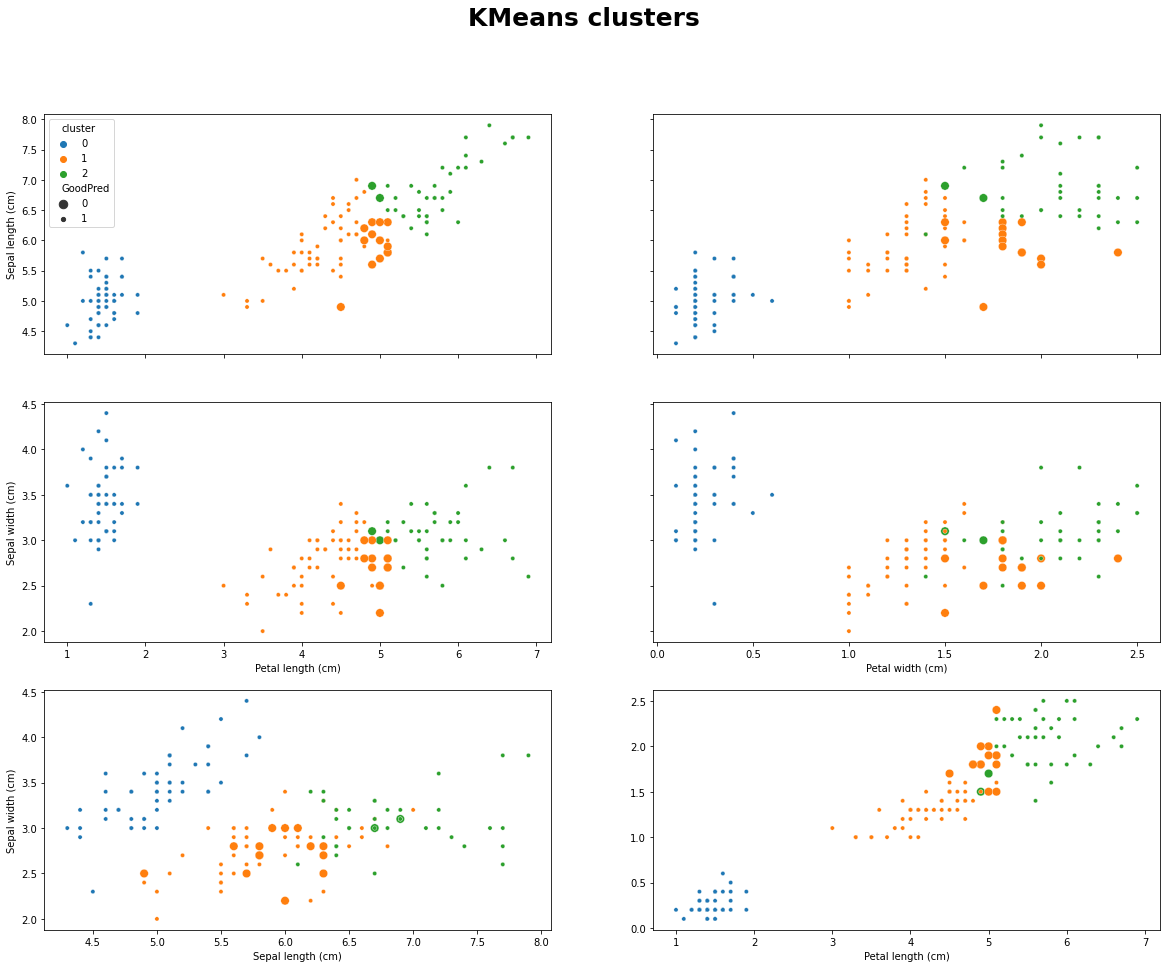

In [ ]:
kmeans["GoodPred"] = np.where(kmeans["target"] == kmeans["cluster"], 1, 0)

# Plotting real clusters
fig, axs = plt.subplots(3, 2, figsize=(20, 15))
sns.scatterplot("petal length (cm)", "sepal length (cm)", hue="iris type", data=kmeans, ax=axs[0, 0])
axs[0, 0].axes.get_xaxis().set_ticklabels([])
axs[0, 0].axes.set_xlabel(None)
axs[0, 0].axes.set_ylabel("Sepal length (cm)")

sns.scatterplot("petal width (cm)", "sepal length (cm)", hue="iris type", data=kmeans, legend=False, ax=axs[0, 1])
axs[0, 1].axes.get_xaxis().set_ticklabels([])
axs[0, 1].axes.set_xlabel(None)
axs[0, 1].axes.get_yaxis().set_ticklabels([])
axs[0, 1].axes.set_ylabel(None)

sns.scatterplot("petal length (cm)", "sepal width (cm)", hue="iris type", data=kmeans, legend=False, ax=axs[1, 0])
axs[1, 0].axes.set_xlabel("Petal length (cm)")
axs[1, 0].axes.set_ylabel("Sepal width (cm)")

sns.scatterplot("petal width (cm)", "sepal width (cm)", hue="iris type", data=kmeans, legend=False, ax=axs[1, 1])
axs[1, 1].axes.get_yaxis().set_ticklabels([])
axs[1, 1].axes.set_xlabel("Petal width (cm)")
axs[1, 1].axes.set_ylabel(None)

sns.scatterplot("sepal length (cm)", "sepal width (cm)", hue="iris type", data=kmeans, legend=False, ax=axs[2, 0])
axs[2, 0].axes.set_xlabel("Sepal length (cm)")
axs[2, 0].axes.set_ylabel("Sepal width (cm)")

sns.scatterplot("petal length (cm)", "petal width (cm)", hue="iris type", data=kmeans, legend=False, ax=axs[2, 1])
axs[2, 1].axes.set_xlabel("Petal length (cm)")
axs[2, 1].axes.set_ylabel(None)

plt.suptitle("Real clusters", fontsize=25, fontweight="bold")
plt.show()

# Plotting KMeans clustering

fig, axs = plt.subplots(3, 2, figsize=(20, 15))
sns.scatterplot("petal length (cm)", "sepal length (cm)", hue="cluster", size="GoodPred", data=kmeans,palette=["C0", "C1", "C2"], ax=axs[0, 0])
axs[0, 0].axes.get_xaxis().set_ticklabels([])
axs[0, 0].axes.set_xlabel(None)
axs[0, 0].axes.set_ylabel("Sepal length (cm)")

sns.scatterplot("petal width (cm)", "sepal length (cm)", hue="cluster",size="GoodPred", data=kmeans,palette=["C0", "C1", "C2"], legend=False, ax=axs[0, 1])
axs[0, 1].axes.get_xaxis().set_ticklabels([])
axs[0, 1].axes.set_xlabel(None)
axs[0, 1].axes.get_yaxis().set_ticklabels([])
axs[0, 1].axes.set_ylabel(None)

sns.scatterplot("petal length (cm)", "sepal width (cm)", hue="cluster",size="GoodPred", data=kmeans,palette=["C0", "C1", "C2"], legend=False, ax=axs[1, 0])
axs[1, 0].axes.set_xlabel("Petal length (cm)")
axs[1, 0].axes.set_ylabel("Sepal width (cm)")

sns.scatterplot("petal width (cm)", "sepal width (cm)", hue="cluster",size="GoodPred", data=kmeans,palette=["C0", "C1", "C2"], legend=False, ax=axs[1, 1])
axs[1, 1].axes.get_yaxis().set_ticklabels([])
axs[1, 1].axes.set_xlabel("Petal width (cm)")
axs[1, 1].axes.set_ylabel(None)

sns.scatterplot("sepal length (cm)", "sepal width (cm)", hue="cluster",size="GoodPred", data=kmeans,palette=["C0", "C1", "C2"], legend=False, ax=axs[2, 0])
axs[2, 0].axes.set_xlabel("Sepal length (cm)")
axs[2, 0].axes.set_ylabel("Sepal width (cm)")

sns.scatterplot("petal length (cm)", "petal width (cm)", hue="cluster",size="GoodPred", data=kmeans,palette=["C0", "C1", "C2"], legend=False, ax=axs[2, 1])
axs[2, 1].axes.set_xlabel("Petal length (cm)")
axs[2, 1].axes.set_ylabel(None)

plt.suptitle("KMeans clusters", fontsize=25, fontweight="bold")
plt.show()




We can see how the clustering works well, and the data is labeled more or less similar as it is in reality. For **setosa** the clusters are alwas perfect, and the discrepancies are seen in the frontiers between **virginica** and **versicolor** (the great points are the ones that are not well labeled). <br>

In order to check the performance quantitatively, we can make a confusion matrix.

In [ ]:
kmeans_confusion = confusion_matrix(kmeans["target"], kmeans["cluster"], normalize="all")
                               
print(kmeans_confusion)


[[0.33333333 0.         0.        ]
 [0.         0.32       0.01333333]
 [0.         0.09333333 0.24      ]]


As I have already said, the Setosa type has been classified perfectly, and the discrepancies are found between Versicolor and Virginica. For the Versicolor the data that corresponds to this species has been classified very good, with 97 % of the samples well classified. The major problem is found in the Virginica type, since some of these samples have been wrongly classified in the Versicolor set. <br>

Overall, we can say that KMeans is a good clustering method to clusterize this kind of data.

### **4) Use a random forest classification and express which is the importance of each feature to infer the type of plant.**

Random Forests is an algorithm that aggregates the results of an ensemble of decision trees. Random Forests randomizes the ensembled trees by sampling with replacement and it uses a random subset of features to build them. In this way, instead of using only one tree, which can lead to overfitting, uses a lot of them and averages the probabilistic prediction of each tree of the algorithm. 

First we will split the data in training and test sets. And then build the Random Forest Classifier.


In [50]:
# Splitting the data
iris_train, iris_test = train_test_split(irisdf, test_size=0.3, random_state=0)

RandForest = RandomForestClassifier(random_state=0, oob_score=True)
RandForest.fit(irisdf.iloc[: ,0:4], irisdf["iris type"])
RandForest_imp = RandForest.feature_importances_
RandForest.oob_score_



0.9533333333333334

The **out-of-the-bag-accuracy** is a measurement of the accuracy that, instead of using a test set as other algorithms, it uses the data that has not been used to build a given individual tree to test the accuracy of the predictions. In this case we see that it is higher than 95%.

In [51]:
# Confusion Matrix
iris_pred = RandForest.predict(iris_test.iloc[:,0:4])
confusion_matrix(iris_test["iris type"], iris_pred, normalize="all")

array([[0.35555556, 0.        , 0.        ],
       [0.        , 0.4       , 0.        ],
       [0.        , 0.        , 0.24444444]])

The data has been classified perfectly, but we have to take into account that this is the data used to buil the model and is a supervised algorithm, we can not compare this results with KMeans. <br>
Also it is worth to mention that the out-of-the-bag accuracy is not 100%, which means that we can not be sure that new data will be classified perfectly.<br>
One good thing about Random Forests is that we can use new data to improve our model without to reconstruct the whole model.

We can obtain the importance of each feature that has been computed for the model. What it is calculated here is the gini index or impurity of each feature. 

In [52]:
FeatImp = pd.DataFrame(data=RandForest_imp.transpose(), index=list(irisdf)[0:4], columns=["Random Forests Feature Importance"])
FeatImp

,Random Forests Feature Importance
sepal length (cm),0.090908
sepal width (cm),0.024531
petal length (cm),0.460445
petal width (cm),0.424116


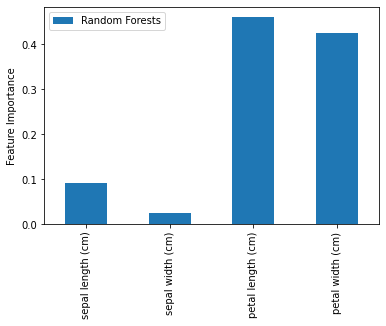

In [ ]:
# Feature importances
FeatImp.plot.bar()
plt.ylabel("Feature Importance")
plt.show()

The most importance variables are the petal length and petal width. This has been already seen at the beggining, when analyzing the dataset, where I have said that the distributions of these two variables had apparently different distributions for each iris kind. <br>

We could have used this information for example for the KMeans clustering, and cluster using only these two variables. 

### **5) Analyze the dependence (or independence) of each one of the features within the data set.**

In order to check the depencencies or independencies in the dataset I will see how the variables are correlated between them. Previously, we have had a first sight on this when plotting the pairplots for the features, and it has been seen that some features had more correlation than others. 

I will use two statistics to test the dependencies, the **Pearson Correlation Coefficient**, which assesses linear relationships, and the **Spearman's Correlation Coefficient**, which assesses monotonic relationship between variables (wether linear or not). 

The **Pearson Correlation Coefficient** is well known in statistics and it uses the covariance between two variables to see how these two variables covary together, but when the relationship is non linear, this coefficient may be misleading. 

On the other hand, the **Spearman's rank Correlation Coefficient**, which is not as "famous" as the Pearson's Coefficient, measures how similar is the rank (relative position label of the observation within the variable) between two variables. The highest the similarity of the rank the highest the Separman's Coefficient. In this way, we can know that indeed the variables are dependant although we don't know which kind of relationship they follow. 

To show it with an example, if the two variables fit perfectly a parabola, the Pearson's Correlation Coefficient won't indicate any correlation, but if we look the plot we will see clearly that the two variables are correlated, and if we fit the data with a second order equation we will be able to predict one variable knowing the other. In this case, the Spearman's rank will be high, waht means that the data is indeed correlated, although it won't tell us it is a second order relationship, we will have a valuable information that we did not have with only the Pearson's Correlation Coefficient.


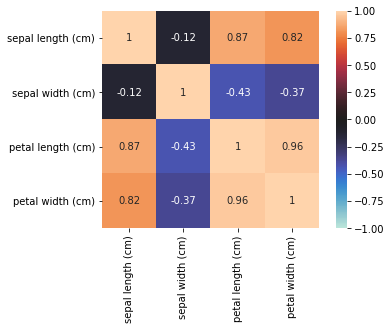

In [12]:
# Heatmap Rcoeff
Rcoeff = irisdf.iloc[:,0:4].corr()
sns.heatmap(Rcoeff, vmin=-1, vmax=1, center=0, square=True, annot=True)
plt.show()

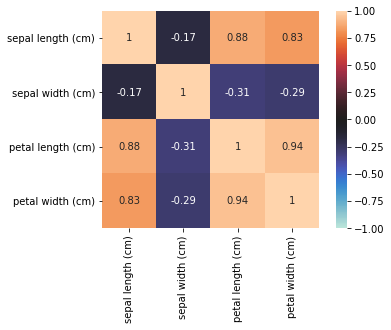

In [13]:
Scoeff = irisdf.iloc[:,0:4].corr("spearman")
sns.heatmap(Scoeff, vmin=-1, vmax=1, center=0, square=True, annot=True)
plt.show()

From both coefficients we can extract more or less the same comclusions. The more dependent are the petal length and petal width. And both have also quite high correlation with the sepal length. <br>
Then, sepal width is quite independent, since it has low correlation with all the other features. And the two variables that are more independent between them are sepal length and sepal width, as we can see in the heatmaps.


### **If we assign the following numerical values: Setosa=0, Versicolour=1, and Virginica=2 and we propose the following causal model:** <br> **Sepal Length -> Sepal Width -> Plant Type <- Petal Width <- Petal Length** 

#### **a) Which relation of independence we should expect between Sepal Length and Petal Length? Check it.**



The causal model that e have is a **directed causal model**, and there is no direct cause between Sepal Length and Petal Length, since there is no arrow pointing directly from one to the other, instead, we have an **indirect cause** between them, since their relation is dependent of another vertices in the causal explanation. Among the undirected path that joins the to variables there exists a **collider**, which is a vertex with arrows pointing into it from both directions. Therefore, the Sepal Length and Petal Length should be **independent**, since a collider, when unconditionate, blocks the transmission of causal effects along a path. 

In order to check it we will have to define the independence of the d-separation statements. D-separation gives the necessary and sufficient conditions for two vertices to be observationally independent upon conditioning on some other set of vertices. 

First we define a basis set, which is the minimum set of d-separated statements. 

*{(SepLen, PlType),(SepLen,PetWid),(SepLen,PetLen),(SepWid,PetWid),(SepWid,PetLen),(PlType, PetLen)}*

In this case we want to know the independence of the none adjacent vertix (SepLen, PetLen) which has no causal parent, and the d-separation statement is *SepLen || PetLen*

First we have to test if the variables are normally distributed. For this we will use a **Kolmogorov-Smirnov** test.

In [57]:
test_seplen = st.kstest(irisdf["sepal length (cm)"], "norm")
test_petlen = st.kstest(irisdf["petal length (cm)"], "norm")

print("P-value Sepal Length = %s" %(format(test_seplen.pvalue, ".0E")))
print("P-value Petl Length = %s" %(format(test_petlen.pvalue, ".0E")))

P-value Sepal Length = 0E+00
P-value Petl Length = 1E-136


As the null hypothesis is that the data is nromally distributed, we can assume that this is true since p-vale < 0.05.

Now we will test linearity and independence:

In [84]:
test_independence = st.pearsonr(irisdf["sepal length (cm)"], irisdf["petal length (cm)"])
print("Pearson Correlation Coefficient: %s" %test_independence[0])


Pearson Correlation Coefficient: 0.8717537758865831


In [78]:
# Calculating independence
t = test_independence[0]*np.sqrt(150-2) / np.sqrt(1-test_independence[0]**2)
p1 = 1 - st.t.cdf(t, df = 148)
print("p-value: %s" %p1 )

p-value: 0.0


We see that the Pearson Correlation Coefficient is close to 0.9, so we can assume linearity on the data, and the p-value < 0.05. This p-value indicates that the true population correlation coefficient is different than 0, since the null hypothesis is that is is equal to 0.

Therefore, the assumption of the causal model seems to be wrong, since these two values seem that are not independent 

#### **b) And if we condition on Plant type?**

In this case we expect that the variables are **dependent**, since we are conditioning on a collider, what means that we are making it inactive, so each change on one of the variable will lead to a change in the other variable. 

In order to check it, we will have to compute the partial correlation between the variables while conditioning the plant type.

In [68]:
# Covariance matrix
cov_matrix = irisdf[["sepal length (cm)", "petal length (cm)", "target"]].cov()
cov_matrix

,sepal length (cm),petal length (cm),target
sepal length (cm),0.685694,1.274315,0.530872
petal length (cm),1.274315,3.116278,1.372483
target,0.530872,1.372483,0.671141


In [74]:
# Inversed covariance matrix
cov_matrix_inv = np.linalg.inv(cov_matrix)
partial_seplen_petlen = cov_matrix_inv[0,1]
print("Partial covariance between SepLen and PetLen: %s" %partial_seplen_petlen)

Partial covariance between SepLen and PetLen: -4.04292659651615


In [75]:
# Partial correlation between Sepal and Petal length
partial_corr = -partial_seplen_petlen / np.sqrt(cov_matrix_inv[0,0]*cov_matrix_inv[1,1])
print("Partial correlation coefficient between SepLen and PetLen: %.3f" %partial_corr)

Partial correlation coefficient between SepLen and PetLen: 0.658


We calculate again the t statistic:

In [79]:
t_condition = partial_corr*np.sqrt(150-2) / np.sqrt(1-partial_corr**2)

# P-value

p2 = 1 - st.t.cdf(t_condition, df = 148)
print("p-value: %s" %p2)

p-value: 0.0


Again we observe that the two variables show **no independence**. This time it was expected by the model, since the collider that is in the path between the variables was inactive.

#### **And if we condition on Petal Width?**

This time we expect no changes when conditioning on Petal Width, since is in the path between the variables but it is not a collider, so conditioning on it means to activate it. If there was non a collider between the variables this step would change the causality, and the variables will go from dependent to independent, but the variables are already **unconditionally independent** due to the presence of the collider, so conditioning on petal width shouldn't change anything.

As before, we will check it again using partial correlation:

In [80]:
# Covariance matrix
cov_matrix = irisdf[["sepal length (cm)", "petal length (cm)", "petal width (cm)"]].cov()
cov_matrix

,sepal length (cm),petal length (cm),petal width (cm)
sepal length (cm),0.685694,1.274315,0.516271
petal length (cm),1.274315,3.116278,1.295609
petal width (cm),0.516271,1.295609,0.581006


In [81]:
# Inversed covariance matrix
cov_matrix_inv = np.linalg.inv(cov_matrix)
partial_seplen_petlen = cov_matrix_inv[0,1]
print("Partial covariance between SepLen and PetLen conditioning on Petal Width: %s" %partial_seplen_petlen)

Partial covariance between SepLen and PetLen conditioning on Petal Width: -3.380337147561255


In [82]:
# Partial correlation between Sepal and Petal length
partial_corr = -partial_seplen_petlen / np.sqrt(cov_matrix_inv[0,0]*cov_matrix_inv[1,1])
print("Partial correlation coefficient between SepLen and PetLen conditioning on Petal Width: %.3f" %partial_corr)

Partial correlation coefficient between SepLen and PetLen conditioning on Petal Width: 0.542


In [83]:
t_condition = partial_corr*np.sqrt(150-2) / np.sqrt(1-partial_corr**2)

# P-value

p3 = 1 - st.t.cdf(t_condition, df = 148)
print("p-value: %s" %p3)

p-value: 3.943512183468556e-13


Again, the variables are still not independent.

We can conclude that the proposed causal structure is not supported by the data. So we should, at least, add a causal relationghip between Sepal Length and Petal Length, then we should analyze all the d-separation statements. And if we want to make a more sofisticated model we could use Wright's Path Analysis to ensure that our model is supported by the data. 